# STEP 1: Pre-processing

## Import necessary packages

In [2]:
import os

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms # Python has packages for specific domains: torchvision, torchaudio, torchtext. These include datasets among others.
from torchvision.transforms import ToTensor

## Data transformation and retrieval

Here we will use the MNIST dataset, which we can load using a dedicated PyTorch module 'Dataset'.
The Dataset module includes many built in datasets (full list: https://pytorch.org/vision/stable/datasets.html), but also supports custom datasets.
Upon calling this module we will specify data transformations we want to apply.

In [3]:
# Define a series of transformations to apply to the input images
transformations = transforms.Compose([
    # Transform a grayscale image to RGB. MNIST is originally in grayscale (1 channel with value range: 0-255)
    transforms.Grayscale(num_output_channels=3),
    # Resize the image to 256x256 pixels. This ensures that all input images have a uniform size.
    transforms.Resize(256), 
    # Center crop the image to 224x224 pixels. This removes any borders and focuses on the central part of the image.
    transforms.CenterCrop(224),
    # Convert the image to a PyTorch tensor. This also effectively changes the value range from 0-255 to 0-1. 
    transforms.ToTensor(),
    # Optionally, we will feed our dataset to a pretrained AlexNet (https://pytorch.org/hub/pytorch_vision_alexnet/). 
    # This model requires the images to be normalized using these values.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# We then download the data using the specified transformations
download_path = os.path.join("data") # Specify location to store MNIST data. This is an OS-friendly way of specifying the path. Change as desired.
# Create the folder if doesn't exist.
if not os.path.exists(download_path):
    os.makedirs(download_path)

train_data = datasets.MNIST(download_path, train=True, download=True, transform=transformations) # Create a dataset for training
test_data = datasets.MNIST(download_path, train=False, download=True, transform=transformations) # Create a dataset for testing (train=False!)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2977548.43it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 277928.50it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2002609.98it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4545580.71it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



## PyTorch DataLoader
PyTorch has another module called DataLoader (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).
This module helps with sampling and iterating over the Dataset object created earlier. This also helps with sampling batches of images during training, instead of feeding single images.
Additionally, it uses Python's multiprocessing functionality to sample data faster.

In [62]:
# Specify the batch size
batch_size = 50

# Create dataloaders for the training and test datasets respectively
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

The DataLoader is a generator, meaning that it does not store its contents in memory (as with a Python list).
In order to access its contents we need to loop over it, or alternatively call a batch with next(iter(DataLoader object))

In [63]:
# Printing the dataloader object directly won't show its contents. Instead you see where the object itself is stored in memory.
print(train_loader)

In [64]:
# Let's have a look at what it yields.
sample = next(iter(train_loader))
sample

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

The Dataloader returns both the image data, and the corresponding labels.
Let's split these up and take a closer look at the structure of these variables.

In [65]:
sample_images, sample_labels = next(iter(train_loader))
print(f"Sample_data shape: {sample_images.shape}")
print(f"Sample_labels shape: {sample_labels.shape}")

Sample_data shape: torch.Size([50, 3, 224, 224])
Sample_labels shape: torch.Size([50])


As you can see, both variables are batches of 50. The image additionally has 3 channels (RGB), each with a size of 224 by 224 pixels.
Looking at 'sample_labels', we can see it contains the true digit labels of the corresponding images.

In [66]:
sample_labels

tensor([7, 6, 0, 2, 1, 7, 7, 0, 0, 7, 4, 5, 9, 8, 7, 4, 4, 2, 3, 3, 8, 1, 0, 8,
        8, 1, 7, 9, 3, 8, 7, 5, 6, 0, 2, 0, 8, 5, 7, 3, 4, 3, 0, 0, 4, 7, 6, 9,
        0, 5])

Let's check the first image as an example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


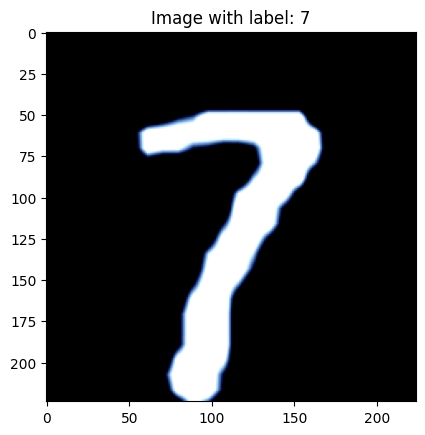

In [67]:
im_id = 0

plt.imshow(sample_images[im_id].permute((1,2,0)))
plt.title(f"Image with label: {sample_labels[im_id]}")
plt.show()

# STEP 2: Create the model

## Check Device for Training
Depending on your system, you can choose whether to train the model on your CPU (Central Processing Unit) or GPU (Graphical Processing Unit).
Choosing to run the training process on your GPU will significantly increase the training speed. In PyTorch you can set the device to 'cuda' (Compute Unified Device Architecture), which is a sort of software interface that allows for general purpose computing on certain types of GPUs.

In [68]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Configures to cuda if it is available.
print(f"Using {device} device")

Using cuda:0 device


## The Model Architecture
Firstly, we need to define the model architecture. In other words, we need to define the amount and types of layers, in which order they are arranged, and how many inputs and outputs there are for each layer. Additionally, we define the activation functions that make the model non-linear. All this information is organized by means of a Python class. The model architecture will thus be contained within an object. 

TODO: We can either choose to highlight the different types of layers one-by-one here, or choose to explain the model line by line (less appropiate for self-study), or highlight the different layers after introducing the full model.

We can put simple schematic pictures here to aid understanding

In [69]:
#create model structure
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(224*224, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10 , kernel_size = 3, stride = 1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
            )
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10*12*12, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits

In [73]:
sample_image, sample_label = next(iter(test_loader))
sample_image.to(device)
flatten = nn.Flatten()
output = flatten(sample_image)
output.size()

torch.Size([50, 150528])